In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import torch.nn.functional as f 
from torch.autograd import Variable
torch.backends.cudnn.deterministic = True
import pandas as pd
import numpy as np
import torch.utils.data as data_utils
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn import metrics
import random 
from matplotlib import pyplot as plt

from sklearn import decomposition

from sklearn import manifold
from scipy import stats

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

In [4]:
number = 1
fileTrain = '/home/franciscoperez/Documents/GitHub/data/BIASEDFATS/Train_rrlyr-'+str(number)+'.csv'
fileTest = '/home/franciscoperez/Documents/GitHub/data/BIASEDFATS/Test_rrlyr-'+str(number)+'.csv'
train_dataset = pd.read_csv(fileTrain, index_col ='Unnamed: 0')
test_dataset = pd.read_csv(fileTest)

In [5]:
try:
    train_dataset =  train_dataset.drop(['Pred', 'Pred2', 'h', 'e', 'u','ID'], axis = 1)
    for col in train_dataset.columns:
        if col not in ['label']:
            if train_dataset[col].var()==0:
                print(col)
                del train_dataset[col]
    test_dataset = test_dataset[list(train_dataset.columns)]
except:
    print(col)
    print('---')

Freq1_harmonics_rel_phase_0
Freq2_harmonics_rel_phase_0
Freq3_harmonics_rel_phase_0


In [6]:
n = train_dataset.shape[0] 
epsilon = 0
input_size = train_dataset.shape[1]-1
hidden_size = 50
hidden_size2 = 50
num_classes = 2
num_epochs = 5
batch_size = 128
learning_rate = 0.001
regularization = False
add_DR_based_data = True


In [7]:
train_dataset = train_dataset.sample(n)
train_dataset.shape


(391501, 61)

In [8]:
test_dataset.shape

(28625, 61)

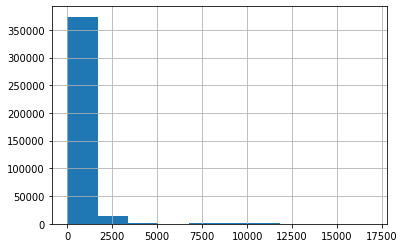

In [9]:
train_dataset['PeriodLS'].hist()
plt.show()

In [10]:
label = train_dataset['label']
del train_dataset['label']


train_dataset_z=(train_dataset-train_dataset.mean())/train_dataset.std()
z_scores = stats.zscore(train_dataset_z)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
train_dataset['label'] = label
train_dataset = train_dataset[filtered_entries]

In [11]:
label = test_dataset['label']
del test_dataset['label']

print(test_dataset.shape)

test_dataset_z=(test_dataset-test_dataset.mean())/test_dataset.std()
z_scores = stats.zscore(test_dataset_z)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
test_dataset['label'] = label

print(test_dataset.shape)

test_dataset = test_dataset[filtered_entries]

(28625, 60)
(28625, 61)


In [12]:
test_dataset.columns

Index(['Amplitude', 'AndersonDarling', 'Autocor_length', 'Beyond1Std',
       'CAR_mean', 'CAR_sigma', 'CAR_tau', 'Con', 'Eta_e',
       'FluxPercentileRatioMid20', 'FluxPercentileRatioMid35',
       'FluxPercentileRatioMid50', 'FluxPercentileRatioMid65',
       'FluxPercentileRatioMid80', 'Freq1_harmonics_amplitude_0',
       'Freq1_harmonics_amplitude_1', 'Freq1_harmonics_amplitude_2',
       'Freq1_harmonics_amplitude_3', 'Freq1_harmonics_rel_phase_1',
       'Freq1_harmonics_rel_phase_2', 'Freq1_harmonics_rel_phase_3',
       'Freq2_harmonics_amplitude_0', 'Freq2_harmonics_amplitude_1',
       'Freq2_harmonics_amplitude_2', 'Freq2_harmonics_amplitude_3',
       'Freq2_harmonics_rel_phase_1', 'Freq2_harmonics_rel_phase_2',
       'Freq2_harmonics_rel_phase_3', 'Freq3_harmonics_amplitude_0',
       'Freq3_harmonics_amplitude_1', 'Freq3_harmonics_amplitude_2',
       'Freq3_harmonics_amplitude_3', 'Freq3_harmonics_rel_phase_1',
       'Freq3_harmonics_rel_phase_2', 'Freq3_harmonics_re

In [13]:
samples = 100
number_columns = train_dataset.shape[1]
if add_DR_based_data:
    for i in range(0):
        new_data = pd.DataFrame(train_dataset.sample(1000).mean()).T
        new_data['PeriodLS']= (np.random.uniform(0.2-epsilon,1.0+epsilon))#-minimum_period)/(maximum_period-minimum_period)
        new_data['label'] = 'ClassA'
        frames = [train_dataset, new_data]
        train_dataset = pd.concat(frames)
        frames2= [test_dataset, new_data]
        test_dataset = pd.concat(frames2)
    
    for i in range(0):
        new_data = pd.DataFrame(train_dataset.sample(1000).mean()).T
        new_data['PeriodLS']=(np.random.uniform(0.0,0.2))#-minimum_period)/(maximum_period-minimum_period)
        new_data['label'] = 'ClassB'
        frames = [train_dataset, new_data]
        train_dataset = pd.concat(frames)
        frames2= [test_dataset, new_data]
        test_dataset = pd.concat(frames2)
        
    for i in range(0):    
        new_data = pd.DataFrame(train_dataset.sample(1000).mean()).T
        new_data['PeriodLS']=(np.random.uniform(1.0,1.2))
        new_data['label'] = 'ClassB'
        frames = [train_dataset, new_data]
        train_dataset = pd.concat(frames)
        frames2= [test_dataset, new_data]
        test_dataset = pd.concat(frames2)
        
    for i in range(samples):    
        new_data = pd.DataFrame(0, index=np.arange(1), columns=train_dataset.columns) #pd.DataFrame([train_dataset.sample(1000).mean()]).T
        new_data['PeriodLS']= 1.0
        new_data['label'] = 'Noise'
        frames = [train_dataset, new_data]
        train_dataset = pd.concat(frames)
        
        frames2= [test_dataset, new_data]
        test_dataset = pd.concat(frames2)
               
    for i in range(0):    
        new_data = pd.DataFrame(0, index=np.arange(1), columns=train_dataset.columns) 
        new_data.columns = train_dataset.columns
        new_data['PeriodLS']= 0.2
        new_data['label'] = 'Noise'
        frames = [train_dataset, new_data]
        train_dataset = pd.concat(frames)
        frames2= [test_dataset, new_data]
        test_dataset = pd.concat(frames2)

In [14]:
test_dataset.shape

(22940, 61)

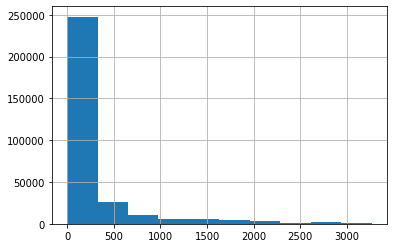

In [15]:
train_dataset['PeriodLS'].hist()
plt.show()

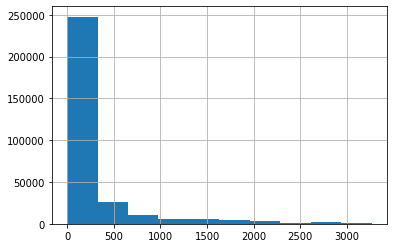

In [16]:
train_dataset['PeriodLS'].hist()
plt.show()

In [17]:
train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.1, random_state=42)

Cases using DR 1: Period $ \in [0.2,1.0]$ days

In [18]:
train_dataset['label'] = train_dataset['label'].str.replace('ClassA', '1')
train_dataset['label'] = train_dataset['label'].str.replace('ClassB', '0')
train_dataset['label'] = train_dataset['label'].str.replace('Noise', '0.5')
train_target = torch.tensor(train_dataset['label'].values.astype(np.float32))
train = torch.tensor(train_dataset.drop('label', axis = 1).values.astype(np.float32)) 
train = f.normalize(train)
train_tensor = data_utils.TensorDataset(train, train_target) 
train_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = batch_size)

In [19]:
val_dataset['label'] = val_dataset['label'].str.replace('ClassA', '1')
val_dataset['label'] = val_dataset['label'].str.replace('ClassB', '0')
val_dataset['label'] = val_dataset['label'].str.replace('Noise', '0.5')
val_target = torch.tensor(val_dataset['label'].values.astype(np.float32))
val = torch.tensor(val_dataset.drop('label', axis = 1).values.astype(np.float32)) 
val = f.normalize(val)
val_tensor = data_utils.TensorDataset(val, val_target) 
val_loader = data_utils.DataLoader(dataset = val_tensor, batch_size = batch_size)

In [20]:
test_dataset['label'] = test_dataset['label'].str.replace('ClassA', '1')
test_dataset['label'] = test_dataset['label'].str.replace('ClassB', '0')
test_dataset['label'] = test_dataset['label'].str.replace('Noise', '0.5')
test_target = torch.tensor(test_dataset['label'].values.astype(np.float32))
test = torch.tensor(test_dataset.drop('label', axis = 1).values.astype(np.float32)) 
test = f.normalize(test)
test_tensor = data_utils.TensorDataset(test, test_target) 
test_loader = data_utils.DataLoader(dataset = test_tensor, batch_size = batch_size)

In [21]:
val_dataset.head()

,Amplitude,AndersonDarling,Autocor_length,Beyond1Std,CAR_mean,CAR_sigma,CAR_tau,Con,Eta_e,FluxPercentileRatioMid20,...,Skew,SlottedA_length,SmallKurtosis,Std,StetsonK,StetsonK_AC,StructureFunction_index_21,StructureFunction_index_31,StructureFunction_index_32,label
140278,0.04100,0.353641,2,0.293333,27.022405,0.633424,0.502754,0.010067,15.970651,0.147059,...,0.033762,5.17560,0.173618,0.019807,0.784575,0.793508,1.900083,2.781423,1.500884,0
334971,0.01375,0.306024,1,0.300000,21.439213,0.632475,0.740517,0.000000,80.348071,0.200000,...,-0.032523,0.11075,-0.104968,0.007513,0.815264,0.676657,1.614281,2.095398,1.424860,0
65187,0.15450,0.229307,6,0.326316,113.209019,0.893887,0.117455,0.000000,0.449903,0.163121,...,0.222094,15.38432,-0.656564,0.082018,0.825269,0.786919,1.697701,2.267816,1.349715,0
256981,0.02150,0.199418,2,0.353333,23.161614,0.906462,0.651597,0.000000,4.664348,0.142857,...,-0.191908,5.69916,-0.241305,0.010936,0.808446,0.741537,1.983826,2.939402,1.532537,0
19762,0.10100,0.037680,4,0.350000,37.812630,0.350146,0.319722,0.010204,0.592477,0.184358,...,-0.284957,11.76435,-0.410545,0.052218,0.820234,0.846281,1.808686,2.524009,1.450604,0


In [22]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size,hidden_size2, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        #self.relu = nn.ReLU()
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size2)  
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, num_classes) 
        #self.sigmoid = nn.Sigmoid()
        #self.dropout = nn.Dropout(p=0.1)
        #self.batchnorm1 = nn.BatchNorm1d(hidden_size)
        #self.batchnorm2 = nn.BatchNorm1d(hidden_size)
        
        
    def forward(self, x):
        out1 = self.fc1(x)
        #out = self.batchnorm1(out)
        #out = self.relu(out)
        out = self.relu(out1)
        out2 = self.fc2(out)
        #out = self.batchnorm1(out)
        out = self.relu2(out)
        out3 = self.fc3(out)
        #x = self.dropout(x)
        #out = self.sigmoid(out)
        return out3, out2, out1
    
net = Net(input_size, hidden_size, hidden_size2, num_classes)
net.cuda()   

Net(
  (fc1): Linear(in_features=60, out_features=50, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=50, out_features=2, bias=True)
)

In [23]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()  

#criterion = nn.BCELoss()
#criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)  

In [24]:
# Train the Model   
hist_train = []
hist_val = []

for epoch in range(num_epochs):
    print('-----------Training----------------------------')
    epoch_loss = 0.0
    running_loss = 0.0
    for i, (star, labels) in enumerate(train_loader):
        star = Variable(star.view(-1, input_size)).cuda()
        labels = Variable(labels).cuda()
        optimizer.zero_grad()  # zero the gradient buffer
        outputs, _, _ = net(star)
        #print(softmax(outputs))
        #m = nn.Sigmoid()
        
        loss = criterion(outputs, labels.long())
        
        if regularization:
            regularization_method(net.params())
                
        loss.backward()
        optimizer.step()
        
        epoch_loss += outputs.shape[0] * loss.item()      
        running_loss += loss.item()
        
        if i % 200 == 199:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
        
    hist_train.append(epoch_loss)
    print(epoch+1, epoch_loss / len(train_loader))
    print('-----------Validation----------------------------')
    epoch_loss = 0.0
    running_loss = 0.0
    for i, (star, labels) in enumerate(val_loader):  
        star = Variable(star.view(-1, input_size)).cuda()
        labels = Variable(labels).cuda()
        optimizer.zero_grad()  # zero the gradient buffer
        outputs, _, _ = net(star)
        loss = criterion(outputs, labels.long())    
        epoch_loss += outputs.shape[0] * loss.item()      
        running_loss += loss.item()
        
        if i % 200 == 199:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    print(epoch+1, epoch_loss / len(val_loader))
    hist_val.append(epoch_loss)


-----------Training----------------------------
[1,   200] loss: 0.036
[1,   400] loss: 0.022
[1,   600] loss: 0.018
[1,   800] loss: 0.015
[1,  1000] loss: 0.013
[1,  1200] loss: 0.013
[1,  1400] loss: 0.011
[1,  1600] loss: 0.010
[1,  1800] loss: 0.010
[1,  2000] loss: 0.009
1 19.32793630219585
-----------Validation----------------------------
[1,   200] loss: 0.008
1 9.899358083152523
-----------Training----------------------------
[2,   200] loss: 0.008
[2,   400] loss: 0.007
[2,   600] loss: 0.007
[2,   800] loss: 0.007
[2,  1000] loss: 0.006
[2,  1200] loss: 0.006
[2,  1400] loss: 0.006
[2,  1600] loss: 0.006
[2,  1800] loss: 0.005
[2,  2000] loss: 0.005
2 8.04857748278493
-----------Validation----------------------------
[2,   200] loss: 0.005
2 6.113621626840905
-----------Training----------------------------
[3,   200] loss: 0.005
[3,   400] loss: 0.005
[3,   600] loss: 0.005
[3,   800] loss: 0.005
[3,  1000] loss: 0.004
[3,  1200] loss: 0.005
[3,  1400] loss: 0.004
[3,  1600]

In [25]:
# Test the Model
correct = 0
total = 0
for star, labels in test_loader:
    images = Variable(star.view(-1, input_size)).cuda()
    outputs, _, _ = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted.cpu() == labels.long()).sum()
print('Accuracy of the network on test objects: %d %%' % (100 * correct / total))
acc_testing = 100 *correct / total
print(np.asarray(acc_testing))

Accuracy of the network on test objects: 78 %
78


In [26]:
def regularization_method(params):
    l1_regularization = 0
    l2_regularization = 0
    lambda1 = 0.001
    lambda2 = 0.001
    for param in params:
        l1_regularization += torch.norm(param, 1)**2
        l2_regularization += torch.norm(param, 2)**2
    loss = loss + lambda1*l1_regularization + lambda2*l2_regularization

In [27]:
correct = 0
total = 0
for star, labels in train_loader:
    images = Variable(star.view(-1, input_size)).cuda()
    outputs, _, _ = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted.cpu() == labels.long()).sum()
print('Accuracy of the network on train objects: %d %%' % (100 * correct / total))
acc_training = 100 *correct / total

Accuracy of the network on train objects: 99 %


In [28]:
# Save the Model
torch.save(net.state_dict(), 'model.pkl')

In [29]:
def softmax(x): 
    return x.exp() / (x.exp().sum(-1)).unsqueeze(-1)

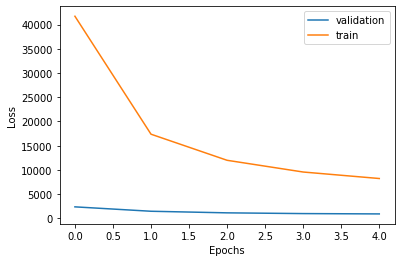

In [30]:
plt.plot(hist_val, label ='validation')
plt.plot(hist_train, label ='train')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.savefig('images/'+str(samples)+'_'+str(epsilon)+'_'+str(n)+"_"+str(hidden_size)+"_Loss_Training.png")
plt.show()

In [31]:
csv_file = open("size_MLP_noise.csv", "a")
csv_file.write(str(np.asarray(acc_testing))+","+str(np.asarray(acc_training))+","+str(samples)+","+str(epsilon)+","+str(n)+","+str(hidden_size)+"\n")
csv_file.close()

In [32]:
def plot_weights(weights, n_weights):

    rows = int(np.sqrt(n_weights))
    cols = int(np.sqrt(n_weights))

    fig = plt.figure(figsize = (20, 10))
    
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(weights[i].view(5, 10).cpu().numpy(), cmap = 'bone')
        #plt.title(str(train_target[i]))
        ax.axis('off')

In [33]:
def get_representations(model, iterator, device):

    model.eval()
    outputs = []
    intermediates = []
    intermediates2 = []
    labels = []

    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y_pred, h2, h1 = net(x)
            outputs.append(y_pred.cpu())
            intermediates.append(h1.cpu())
            intermediates2.append(h2.cpu())
            labels.append(y)
        
    outputs = torch.cat(outputs, dim = 0)
    intermediates = torch.cat(intermediates, dim = 0)
    intermediates2 = torch.cat(intermediates2, dim = 0)
    labels = torch.cat(labels, dim = 0)

    return outputs, intermediates, intermediates2, labels

In [34]:
outputs, intermediates, intermediates2, labels = get_representations(net, train_loader, device)
outputs_test, intermediates_test, intermediates2_test, labels_test = get_representations(net, test_loader, device)

In [35]:
def get_pca(data, data_test=None, n_components = 2):
    pca = decomposition.PCA()
    
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    
    if data_test is not None: 
        pca_data_test = pca.transform(data_test)
        return pca_data, pca_data_test 
    
    return pca_data


def get_tsne(data, data_test = None, n_components = 2, n_curves = None):
    if n_curves is not None:
        data = data[:n_curves]
    tsne = manifold.TSNE(n_components = n_components, random_state = 0)
    tsne_data = tsne.fit_transform(data)
    
    if data_test is not None: 
        tsne_data_test = tsne.transform(data_test)
        return tsne_data, tsne_data_test  
    
    return tsne_data

In [36]:
def plot_representations(data, labels, n_images = None):
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c = labels, alpha =0.1)
    handles, labels = scatter.legend_elements()
    legend = ax.legend(handles = handles, labels = labels)

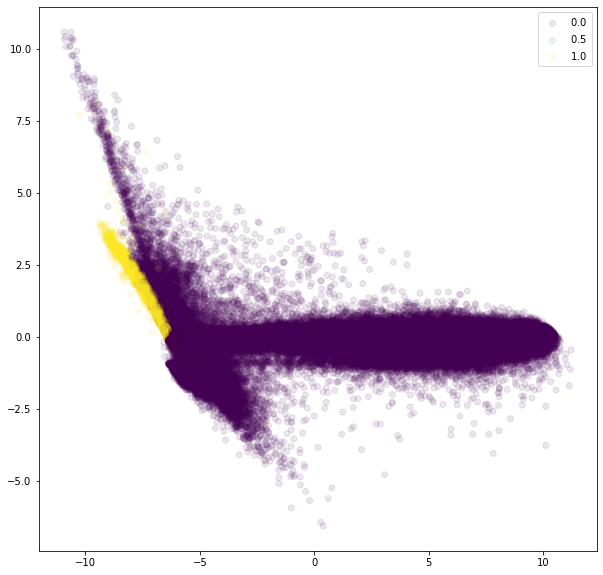

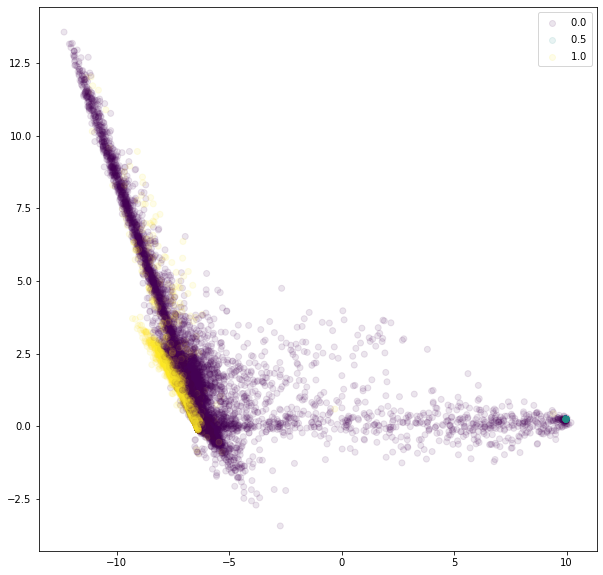

In [37]:
intermediate_pca_data, intermediate_pca_data_test = get_pca(intermediates, data_test=intermediates_test)


plot_representations(intermediate_pca_data, labels)
plot_representations(intermediate_pca_data_test, labels_test)

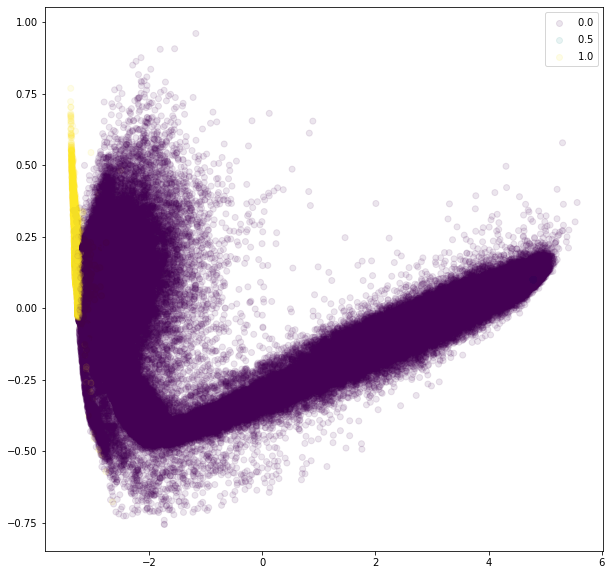

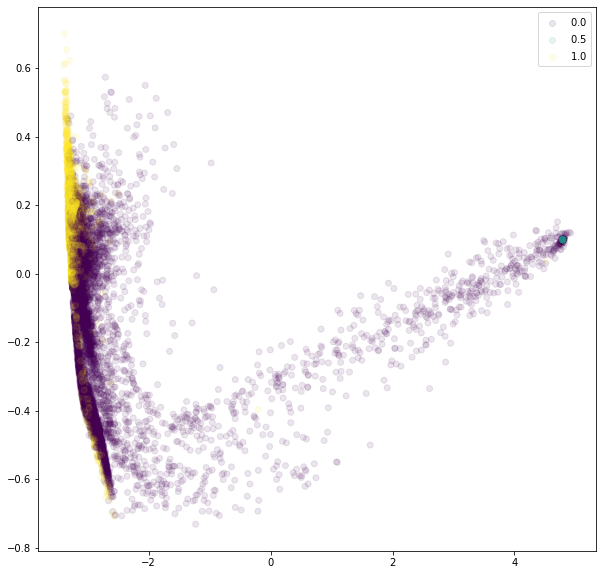

In [44]:
intermediate2_pca_data, intermediate2_pca_data_test = get_pca(intermediates2, data_test=intermediates2_test)
plot_representations(intermediate2_pca_data, labels)
plot_representations(intermediate2_pca_data_test, labels_test)

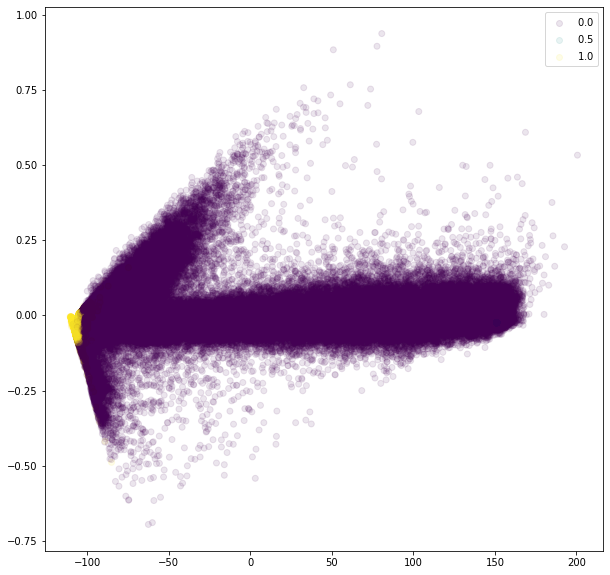

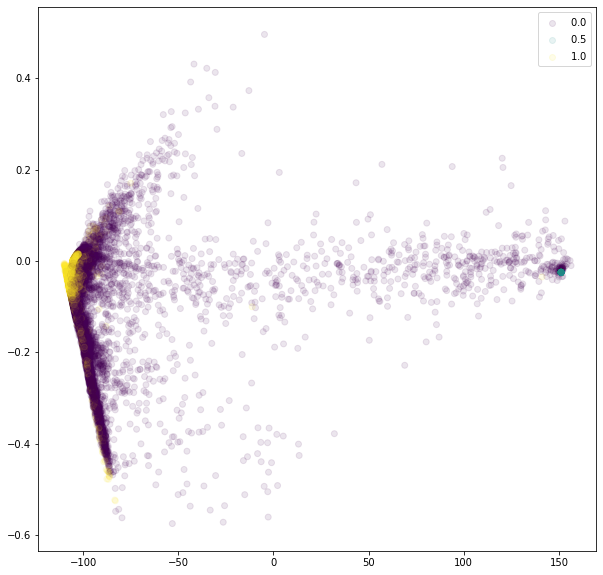

In [45]:
output_pca_data, output_pca_data_test = get_pca(outputs, data_test=outputs_test)
plot_representations(output_pca_data, labels)
plot_representations(output_pca_data_test, labels_test)

In [ ]:
N_CURVES = 100000
intermediate_tsne_data, intermediate_tsne_data_test = get_tsne(intermediates, data_test=intermediates_test, n_curves = N_CURVES)
plot_representations(intermediate_tsne_data, labels, n_curves = N_CURVES)
plot_representations(intermediate_tsne_data_test, labels_test, n_curves = N_CURVES)

In [ ]:
intermediate2_tsne_data, intermediate2_tsne_data_test = get_tsne(intermediates2, data_test=intermediates2_test, n_curves = N_CURVES)
plot_representations(intermediate2_tsne_data, labels, n_curves = N_CURVES)
plot_representations(intermediate2_tsne_data_test, labels_test, n_curves = N_CURVES)

In [ ]:
output_tsne_data, output2_tsne_data_test = get_tsne(output, data_test=output_test, n_curves = N_CURVES)
plot_representations(output_tsne_data, labels, n_curves = N_CURVES)
plot_representations(output_tsne_data_test, labels_test, n_curves = N_CURVES)

In [ ]:
def plot_confusion_matrix(labels, pred_labels):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = metrics.confusion_matrix(labels, pred_labels);
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels = range(10));
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []
    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _, _ = model(x)

            y_prob = f.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs


images, labels, probs = get_predictions(net, test_loader, device)
pred_labels = torch.argmax(probs, 1)

In [ ]:
plot_confusion_matrix(labels, pred_labels)

In [ ]:
np.round(softmax(outputs))

In [ ]:
N_WEIGHTS = 25
weights = net.fc2.weight.data
plot_weights(weights, N_WEIGHTS)

In [ ]:
net.fc1.weight.data.shape